# Import Dependencies

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import scipy.stats
import pandas as pd
from scipy.stats import norm
import datetime
import os

# Setup
## Load data
Load the accumulated sunspot data and set the data into variables.

In [5]:
excel_file = '../data/Accumulated Final Data.xlsx'
df = pd.read_excel(excel_file,sheet_name='Sheet1', header =0)

N = 113
N = N - 1
x_values = df.iloc[0:N,1]
abs_x_values = df.iloc[0:N,15]
x_errors = df.iloc[0:N,2]
y_values = df.iloc[0:N,18]
y_errors = df.iloc[0:N,4]
p_values = df.iloc[0:N,7]

assert len(y_values) == len(x_values)
assert len(y_errors) == len(y_values)

A = 14.713 * (np.pi/(180*24))
B = -2.396 * (np.pi/(180*24))
C = -1.787 * (np.pi/(180*24))

## Plot Graph
Plot a rough graph of the data to ensure everything is working correctly. 

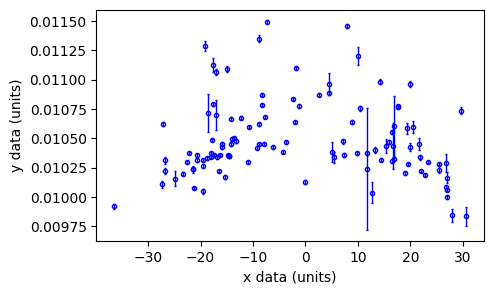

In [6]:
plt.figure(figsize=(5,3))
plt.errorbar(x_values, 
             y_values, 
             yerr=y_errors, # use y_errors array for y error bars
             linestyle='None',
             capsize =1, 
             fmt = 'bo',
             mfc = 'none',
             markersize =3, 
             elinewidth=1,)

plt.xlabel('x data (units)') # axis labels and units
plt.ylabel('y data (units)')
plt.show() 

# $\chi ^2$ Minimization
The equation used to model the latitude of the Sun at a given latitude is

$$
\omega = \text{A} + \text{B}\sin^2(\varphi) + \text{C} \sin ^4 (\varphi).
$$
Here the variables to be optimized are $A$, $B$, and $C$. 

The output are the optimized parameters and the covariance matrix which is used to calculate the errors in the optimized parameters.

In [7]:
def model_function(x, *params):
    return params[0] + params[1]*(np.sin((x*np.pi)/(180)))**2 + params[2]*(np.sin((x*np.pi)/(180)))**4

initial_values = np.array([0.0107, -0.00174, -0.00139])

def chi_squared(model_params, model, x_data, y_data, y_err):
    return np.sum(((y_data - model(x_data, *model_params))/y_err)**2) 

degrees_of_freedom = x_values.size - initial_values.size


popt, cov = scipy.optimize.curve_fit(model_function, 
                                     x_values,
                                     y_values, 
                                     sigma=y_errors, 
                                     absolute_sigma=True, 
                                     p0=initial_values, 
                                     check_finite=True) 

print('Optimised parameters = ', popt, '\n')
print('Covariance matrix = \n', cov)

Optimised parameters =  [ 0.01071307 -0.00406446  0.00649657] 

Covariance matrix = 
 [[ 6.69690287e-12 -1.08832440e-10  3.53250125e-10]
 [-1.08832440e-10  2.73719807e-09 -1.09712451e-08]
 [ 3.53250125e-10 -1.09712451e-08  5.25462935e-08]]


## Calculating Red $\chi ^2$ and Errors
The error is calcualted as

$$

$$

.

In [8]:
chi_squared_min = chi_squared(popt, model_function, x_values, y_values, y_errors)
print('chi^2_min = {}'.format(chi_squared_min))

degrees_of_freedom = x_values.size - popt.size
print('reduced chi^2 = {}'.format(chi_squared_min/degrees_of_freedom))
print('P(chi^2_min, DoF) = {}'.format(scipy.stats.chi2.sf(chi_squared_min, degrees_of_freedom)))


popt_errs = np.sqrt(np.diag(cov))

print(f'A = {popt[0]:.3g} +/- {popt_errs[0]:.3g} units') 
print(f'B = {popt[1]:.3g} +/- {popt_errs[1]:.3g} units')
print(f'C = {popt[2]:.3g} +/- {popt_errs[2]:.3g} units')

chi^2_min = 24693.04217923872
reduced chi^2 = 226.54167136916257
P(chi^2_min, DoF) = 0.0
A = 0.0107 +/- 2.59e-06 units
B = -0.00406 +/- 5.23e-05 units
C = 0.0065 +/- 0.000229 units


# Plotting and Analysis
## Plotting Latitude versus Angular Velocity

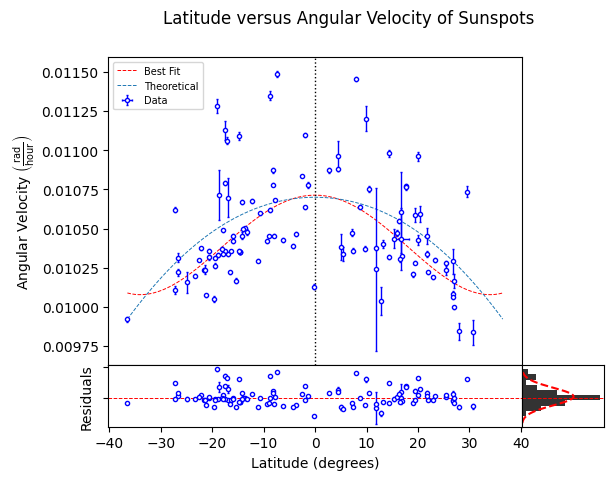

In [9]:
fig, axs = plt.subplots(2, 2,
                        gridspec_kw={'height_ratios': [5, 1], 'width_ratios': [5,1]}
                       , sharey='row'
                       )

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
axs[0,0].set_xticklabels([])  
axs[0, 1].axis('off')
axs[1, 1].tick_params(axis='both', which='both', length=0)  
axs[1, 1].set_xticklabels([])  
axs[1, 1].set_yticklabels([])

axs[0,0].errorbar(x_values,
                  y_values, 
                  yerr = y_errors, 
                  xerr = x_errors, 
                  fmt = 'bo',
            mfc='white',
                  capsize =1, markersize =3, elinewidth=1,    
             linestyle='None',
             zorder =2,
             label = 'Data')

######### Best Fit Line #########

if np.abs(x_values.min()) > np.abs(x_values.max()):
    x_smooth_fit = np.linspace(x_values.min(), -x_values.min(), 100)
else:
    x_smooth_fit = np.linspace(-x_values.max(), x_values.max(), 100)

axs[0,0].plot(x_smooth_fit, 
              model_function(x_smooth_fit,*popt),
              color = 'r', 
              linewidth = 0.7, 
              linestyle='--',
              zorder =1,
              label = 'Best Fit')

######### Theoretical Line #########
axs[0,0].plot(x_smooth_fit,
              A + B*(np.sin((x_smooth_fit*np.pi)/(180)))**2 + C*(np.sin((x_smooth_fit*np.pi)/(180)))**4,
              #color = '',
              linewidth = 0.7, 
              linestyle='--',
              zorder =1,
              label = 'Theoretical')
              


residual = y_values - model_function(x_values, *popt)
axs[1,0].errorbar(x_values, residual, capsize =1, fmt = 'bo',
            mfc='white', 
                  markersize =3, elinewidth=1,yerr=y_errors, linestyle = 'None')

axs[1,0].set_xlabel('Latitude (degrees)') 
axs[0,0].set_ylabel(r'Angular Velocity $\left(\frac{\text{rad}}{\text{hour}}\right)$')

axs[1,0].set_ylabel('Residuals')
axs[1,0].axhline(y=0, color='r', linestyle='dashed', linewidth = 0.7)


theoretical_residual = y_values - (A + B*(np.sin((x_values*np.pi)/(180)))**2 + C*(np.sin((x_values*np.pi)/(180)))**4)


##### Histogram 1#####
axs[1,1].hist(residual, bins =9, orientation='horizontal', color='k', alpha=0.8, density=True)

mu = np.mean(residual)
sigma = np.std(residual, ddof=1)
x_normdist = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y_normdist = norm.pdf(x_normdist, mu, sigma)
axs[1,1].plot(y_normdist, x_normdist, color='r', linestyle='dashed')
axs[1,1].axhline(y=0, color='r', linestyle='dashed', linewidth = 0.7)
x_min, x_max = axs[0, 0].get_xlim()

if np.abs(x_min) > np.abs(x_max):
    axs[1, 0].set_xlim(x_min, -x_min)
    axs[0, 0].set_xlim(x_min, -x_min)
else:
    axs[1,0].set_xlim(-x_max, x_max)
    axs[0, 0].set_xlim(x_min, -x_min)


###########

axs[0,0].axvline(0, color='black', linestyle=':', linewidth=1, zorder=1)

axs[0,0].legend(prop={'size': 7}, loc ='upper left')
fig.suptitle(r'Latitude versus Angular Velocity of Sunspots')
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.path.join

plt.savefig(os.path.join("../graphs/final_plots", f"Latitude-Angular_Velocity-Plot.pdf"), format="pdf", bbox_inches="tight")

## Plotting Absolute Latitude versus Angular Velocity

chi^2_min = 24692.9284541303
reduced chi^2 = 226.54062801954402
P(chi^2_min, DoF) = 0.0
optimised parameter[0] = (0.010713065206178481 +/- 2.5878374889964454e-06) units
optimised parameter[1] = (-0.004064464694885521 +/- 5.2318238360461776e-05) units
optimised parameter[2] = (0.006496574545565971 +/- 0.00022922978321169554) units


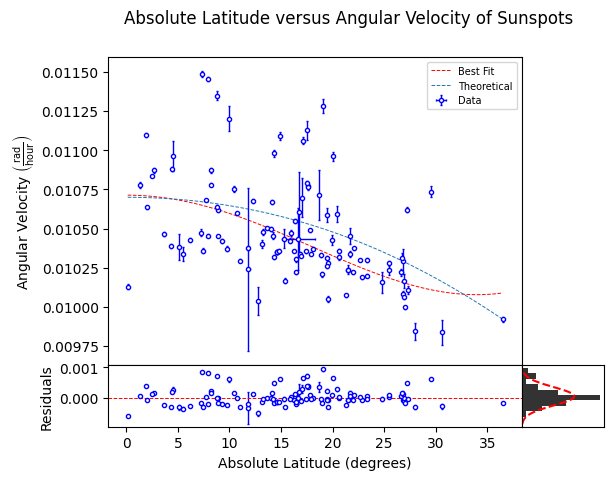

In [11]:
fig, axs = plt.subplots(2, 2,
                        gridspec_kw={'height_ratios': [5, 1], 'width_ratios': [5,1]})

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
axs[0,0].set_xticklabels([])  
axs[0, 1].axis('off')
axs[1, 1].tick_params(axis='both', which='both', length=0)  
axs[1, 1].set_xticklabels([])  
axs[1, 1].set_yticklabels([])


axs[0,0].errorbar(abs_x_values,
                  y_values, 
                  yerr = y_errors, 
                  xerr = x_errors, 
                  fmt = 'bo',
            mfc='white',
                  capsize =1, markersize =3, elinewidth=1,    
             linestyle='None',
             zorder =2,
             label = 'Data')



######### Best Fit Line #########
x_smooth_fit = np.linspace(abs_x_values.min(), abs_x_values.max(), 100)
axs[0,0].plot(x_smooth_fit, 
              model_function(x_smooth_fit,*popt),
              color = 'r', 
              linewidth = 0.7, 
              linestyle='--',
              zorder =1,
              label = 'Best Fit')

######### Theoretical Line #########
axs[0,0].plot(x_smooth_fit,
              A + B*(np.sin((x_smooth_fit*np.pi)/(180)))**2 + C*(np.sin((x_smooth_fit*np.pi)/(180)))**4,
              #color = '',
              linewidth = 0.7, 
              linestyle='--',
              zorder =1,
              label = 'Theoretical')
              
residual = y_values - model_function(abs_x_values, *popt)
axs[1,0].errorbar(abs_x_values, residual, capsize =1, fmt = 'bo',
            mfc='white', 
                  markersize =3, elinewidth=1,yerr=y_errors, linestyle = 'None')

axs[1,0].set_xlabel('Absolute Latitude (degrees)') 
axs[0,0].set_ylabel(r'Angular Velocity $\left(\frac{\text{rad}}{\text{hour}}\right)$')

axs[1,0].set_ylabel('Residuals')
axs[1,0].axhline(y=0, color='r', linestyle='dashed', linewidth = 0.7)


##### Histogram #####
axs[1,1].hist(residual, bins =9, orientation='horizontal', color='k', alpha=0.8, density=True)

mu = np.mean(residual)
sigma = np.std(residual, ddof=1)
x_normdist = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y_normdist = norm.pdf(x_normdist, mu, sigma)
axs[1,1].plot(y_normdist, x_normdist, color='r', linestyle='dashed')

x_min, x_max = axs[0, 0].get_xlim()
axs[1, 0].set_xlim(x_min, x_max)
###########


axs[0,0].legend(prop={'size': 7}, loc ='upper right')
fig.suptitle(r'Absolute Latitude versus Angular Velocity of Sunspots')
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.path.join

#######
chi_squared_min2 = chi_squared(popt, model_function, abs_x_values, y_values, y_errors)
print('chi^2_min = {}'.format(chi_squared_min2))

degrees_of_freedom = abs_x_values.size - popt.size
print('reduced chi^2 = {}'.format(chi_squared_min2/degrees_of_freedom))
print('P(chi^2_min, DoF) = {}'.format(scipy.stats.chi2.sf(chi_squared_min2, degrees_of_freedom)))


popt_errs2 = np.sqrt(np.diag(cov))

for i, (val, err) in enumerate(zip(popt, popt_errs)):
    print('optimised parameter[{}] = ({} +/- {}) units'.format(i, val, err))
    

plt.savefig(os.path.join("../graphs/final_plots", f"Absolute_Latitude-Angular_Velocity-Plot.pdf"), format="pdf", bbox_inches="tight")

## Percent Difference

In [13]:
compare = [
    ["A", popt[0], A, (popt[0] - A), 100*(np.abs(popt[0] - A)/popt[0])],
    ["B", popt[1], B, popt[1] - B, 100*(np.abs(popt[1] - B)/popt[1])],
    ["C", popt[2], C, popt[2] - C, 100*(np.abs(popt[2] - C)/popt[2])]
]
headers = ["", "Calculated Values", "Theoretical Values", "Difference", "Percent Difference"]
compare_df = pd.DataFrame(compare, columns=headers)
print(compare_df)

      Calculated Values  Theoretical Values  Difference  Percent Difference
0  A           0.010713            0.010700    0.000013            0.125731
1  B          -0.004064           -0.001742   -0.002322          -57.130385
2  C           0.006497           -0.001300    0.007796          120.003512


## Percent Error

In [14]:
perc_err = [
    ["A", popt[0], popt_errs[0],  100*(np.abs(popt_errs[0])/popt[0])],
    ["B", popt[1], popt_errs[1],  100*(np.abs(popt_errs[1])/popt[1])],
    ["C", popt[2], popt_errs[2],  100*(np.abs(popt_errs[2])/popt[2])]
]
perc_err_headers = ["", "Optimized Paramaters", "Errors",  "Percent Error"]
per_err_df = pd.DataFrame(perc_err, columns=perc_err_headers)
print(per_err_df)

      Optimized Paramaters    Errors  Percent Error
0  A              0.010713  0.000003       0.024156
1  B             -0.004064  0.000052      -1.287211
2  C              0.006497  0.000229       3.528472
